In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
from scipy.sparse import coo_matrix
from shapely.geometry import Point, LineString, MultiLineString
from shapely import ops
import networkx as nx
import matplotlib.pyplot as plt
import folium
import pickle
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model = '202204_waypoints_DP10_HDBSCAN12_tromso_full_UTM'
model_path = '../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()

In [4]:
network.get_trajectories_info()
network.hyperparameters

Number of AIS messages: 796177
Number of trajectories: 2119
Coordinate Reference System (CRS): EPSG:32632


{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 12,
 'clustering_min_cluster_size': 12,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-02, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-02, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-04]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [5]:
network.prune_graph(1)
#merge_stops = True
#merge_stops_speed = 2
#pruning = 4
#network.merge_stop_points(max_speed=merge_stops_speed)
#network.prune_graph(pruning)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 2181
------------------------


In [6]:
# load evaluation data
eval_file = '202205_points_tromso_cleaned_meta_full_dualSplit_2'
filename = '../data/processed/' + eval_file + '.parquet'
gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
all_trajectories = mpd.TrajectoryCollection(gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 1
selection_end = len(all_trajectories)
selection_step = 3
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = gdf.mmsi.unique()[selection]
trajectories = all_trajectories.filter('mmsi', mmsis.tolist())

In [7]:
#mmsis = ['258002060_1070_2022-05-22 22:24:23', '258002060_928_2022-05-19 18:03:55']
#trajectories = trajectories.filter('mmsi', mmsis)

In [8]:
#for trajectory in trajectories:
#    path, eval = network.trajectory_to_path2(trajectory)

Evaluating graph on 578 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 6.08 minutes
Success rates:
                   mmsi  mean_dist  median_dist  max_dist  distances  fraction_covered
message                                                                               
attempt        0.024221   0.024221     0.024221  0.024221   0.024221          0.024221
no_intersects  0.160900   0.000000     0.000000  0.000000   0.000000          0.160900
no_path        0.003460   0.000000     0.000000  0.000000   0.000000          0.003460
success        0.811419   0.811419     0.811419  0.811419   0.811419          0.811419

 --------------------------- 

Fraction of NaN results: 0.164

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.893 

Mean distance      = 140.60 m
Median distance    = 77.16 m
Standard deviation = 299.76 m 



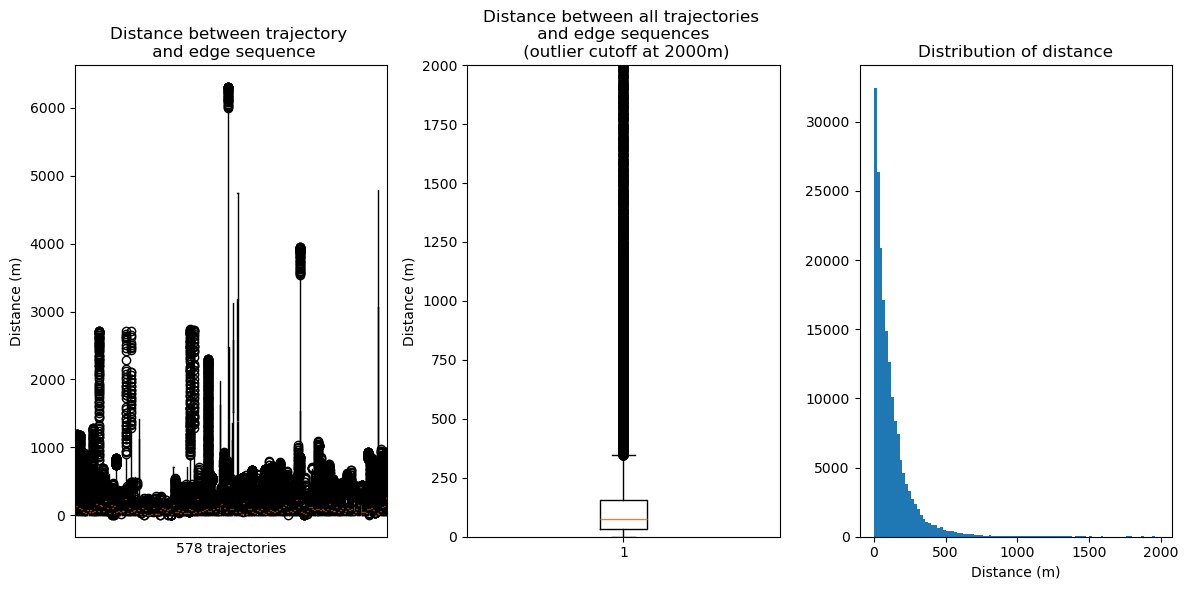

In [9]:
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(trajectories)
fig.show()

In [10]:
# Generate plot
#map = network.map_graph(pruned=True)
#map = trajectories.to_line_gdf()[['geometry', 'mmsi']].explore(m=map, style_kwds={'weight':1, 'color':'black', 'opacity':0.5}, 
#                                                               name='trajectories')
#map = all_paths.explore(m=map, color='yellow', name='paths')
#folium.LayerControl().add_to(map)

#map

In [11]:
#map.save('dummy2.html')

In [12]:
'''
# Save experiment results with neptune
import neptune

run = neptune.init_run(
    project="jandrik91/Maritime-Traffic-Network",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

run["model"]=model
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G_pruned.number_of_nodes()
run["n_edges"]=network.G_pruned.number_of_edges()
run["n_isolated"]=nx.number_of_isolates(network.G_pruned)
run["merge_stops"] = merge_stops
run["merge_stops_speed"] = merge_stops_speed
run["pruning"] = pruning

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["parameters"] = params

run["test_data"] = {'eval_file':eval_file,
                    'selection_start':selection_start,
                    'selection_end':selection_end,
                    'selection_step':selection_step,
                    'n_trajectories':n_trajectories}

run["plot"].upload(fig)
run["summary"] = summary

run.stop()
'''

'\n# Save experiment results with neptune\nimport neptune\n\nrun = neptune.init_run(\n    project="jandrik91/Maritime-Traffic-Network",\n    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",\n)  # your credentials\n\nrun["model"]=model\nrun["n_points"]=len(network.gdf)\nrun["n_nodes"]=network.G_pruned.number_of_nodes()\nrun["n_edges"]=network.G_pruned.number_of_edges()\nrun["n_isolated"]=nx.number_of_isolates(network.G_pruned)\nrun["merge_stops"] = merge_stops\nrun["merge_stops_speed"] = merge_stops_speed\nrun["pruning"] = pruning\n\nparams = network.hyperparameters\nparams[\'clustering_metric_V_coord\'] = params[\'clustering_metric_V\'][0][0]\nparams[\'clustering_metric_V_cog\'] = params[\'clustering_metric_V\'][2][2]\nparams[\'clustering_metric_V_speed\'] = params[\'clustering_metric_V\'][4][4]\nrun["parameters"] = params\n\nrun["test_data"] = {\'eval_fi